In [1]:
import numpy as np
import pandas as pd


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.models import Model
from keras.layers import LSTM

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from math import sqrt

Using TensorFlow backend.
c:\users\dorotka\anaconda3\envs\dataanalitics\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\dorotka\anaconda3\envs\dataanalitics\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\dorotka\anaconda3\envs\dataanalitics\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\dorotka\

In [2]:
import matplotlib.pyplot as plt

def show_y_pred_test(y_pred_df, y_test_df, n=3,size = 100, station_name = ""):
    plt.figure()
    plt.plot(y_pred_df['PM10_Forecast_{}h'.format(n)][:size])
    plt.plot(y_test_df.reset_index()['PM10_Forecast_{}h'.format(n)][:size] )
    plt.title("Forecast {}h {}".format(n, station_name))
    plt.ylabel('PM10')
    plt.xlabel('index')
    plt.legend(['y_predicted', 'y_original'], loc='upper left')
    return plt

# Dane

In [3]:
data = pd.read_csv("./data_preprocessed/2017-2018_single_MpKrakAlKras_with_forecast3_8_12h_cleared.csv")

data.head(5)

,timestamp,MpKrakAlKras-PM10-1g,Weather,Temp(C),Wind(m/s),Direction(deg),Humidity,Barometer(mbar),PM10_Forecast_3h,PM10_Forecast_8h,PM10_Forecast_12h
0,2017-01-01 01:00:00,213.733,Ice fog.,-6.0,1.0,0.0,0.93,10.24,244.690,187.320,121.805
1,2017-01-01 02:00:00,213.868,Ice fog.,-7.0,2.0,190.0,0.93,10.24,224.673,181.194,119.096
2,2017-01-01 03:00:00,221.923,Ice fog.,-4.0,3.0,200.0,0.80,10.23,212.159,161.198,121.681
3,2017-01-01 04:00:00,244.690,Ice fog.,-7.0,3.0,210.0,0.86,10.22,198.375,136.218,138.353
4,2017-01-01 05:00:00,224.673,Ice fog.,-6.0,3.0,200.0,0.80,10.22,191.881,121.805,150.415


In [4]:
X = data[["MpKrakAlKras-PM10-1g","Direction(deg)","Temp(C)","Wind(m/s)","Humidity","Barometer(mbar)"]]

y = data[["PM10_Forecast_3h","PM10_Forecast_8h","PM10_Forecast_12h"]]

In [5]:
data.head(5)

,timestamp,MpKrakAlKras-PM10-1g,Weather,Temp(C),Wind(m/s),Direction(deg),Humidity,Barometer(mbar),PM10_Forecast_3h,PM10_Forecast_8h,PM10_Forecast_12h
0,2017-01-01 01:00:00,213.733,Ice fog.,-6.0,1.0,0.0,0.93,10.24,244.690,187.320,121.805
1,2017-01-01 02:00:00,213.868,Ice fog.,-7.0,2.0,190.0,0.93,10.24,224.673,181.194,119.096
2,2017-01-01 03:00:00,221.923,Ice fog.,-4.0,3.0,200.0,0.80,10.23,212.159,161.198,121.681
3,2017-01-01 04:00:00,244.690,Ice fog.,-7.0,3.0,210.0,0.86,10.22,198.375,136.218,138.353
4,2017-01-01 05:00:00,224.673,Ice fog.,-6.0,3.0,200.0,0.80,10.22,191.881,121.805,150.415


In [6]:
scaler = StandardScaler()
X_scale = pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
X_scale.head()

,MpKrakAlKras-PM10-1g,Direction(deg),Temp(C),Wind(m/s),Humidity,Barometer(mbar)
0,3.406057,-1.229537,-1.641839,-1.06963,0.922469,1.009585
1,3.408971,0.461359,-1.747499,-0.62705,0.922469,1.009585
2,3.582857,0.550354,-1.430521,-0.18447,0.165148,0.881591
3,4.074335,0.639348,-1.747499,-0.18447,0.514681,0.753597
4,3.642222,0.550354,-1.641839,-0.18447,0.165148,0.753597


# PCA

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

X_pca = pca.fit_transform(X_scale)

In [8]:
#weather_id trzeba by dodać jako one-hot a nie słownik, tylko że wtedy mamy 100 dodatkowych kolumn

train_X, test_X, train_y, test_y = train_test_split(X_pca, y, test_size=0.1,
                                                    random_state=0)

In [9]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Model

In [10]:
model = Sequential()
# 50 neurons in first hidden layer
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(3,kernel_initializer='normal', activation='linear'))
model.compile(loss='mae', optimizer='adam')

In [11]:
model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

In [12]:
y_pred = model.predict(test_X)
rms = sqrt(mean_squared_error(test_y, y_pred))
rms

32.81244846671691

In [13]:
now = np.array([[20,210,-8,3,0.8 ,10]])
n=scaler.transform(now)
n = pca.transform(n)
nnn = n.reshape((n.shape[0], 1, n.shape[1]))

pred = model.predict(nnn)
pred
#def predict(condtions):
#    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=96)
#    score = model.predict([x_test])[0]

array([[46.369328, 41.937252, 40.12158 ]], dtype=float32)

### Podsumowanie

In [14]:
_, X_test_orig, _, y_test_orig = train_test_split(X, y, test_size=0.1,
                                                    random_state=0)

y_test_orig = y_test_orig.sort_index()
X_test_orig = X_test_orig.sort_index()

X_test_scaler = pd.DataFrame(scaler.transform(X_test_orig),columns=X_test_orig.columns)
X_test_pca = pca.transform(X_test_scaler)
X_test_pca = X_test_pca.reshape((X_test_pca.shape[0], 1, X_test_pca.shape[1]))

y_pred = model.predict(X_test_pca)
y_pred_df = pd.DataFrame(y_pred,columns=y_test_orig.columns)
y_pred_df.head()

,PM10_Forecast_3h,PM10_Forecast_8h,PM10_Forecast_12h
0,144.233170,128.317352,120.562904
1,103.612152,101.069016,99.053123
2,127.742096,113.977371,107.326042
3,143.336777,127.435196,119.703224
4,70.426315,64.325279,62.138416


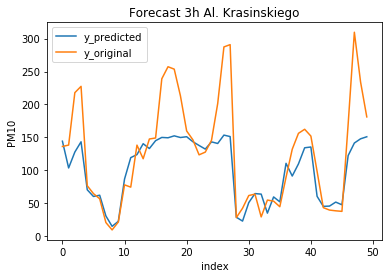

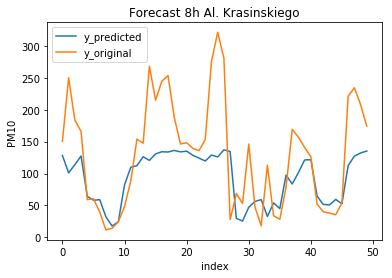

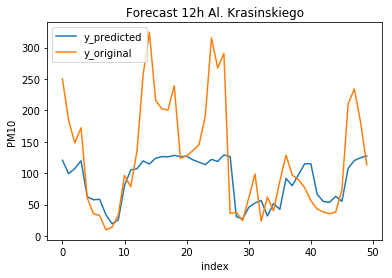

In [15]:
for n in (3, 8, 12):
    show_y_pred_test(y_pred_df, y_test_orig, n=n, size=50, station_name="Al. Krasinskiego")

# To samo dla ul Bujaka

In [16]:
data = pd.read_csv("./data_preprocessed/2017-2018_single_MpKrakBujaka_with_forecast3_8_12h_cleared.csv")

data.head(5)

,timestamp,MpKrakBujaka-PM10-1g,Weather,Temp(C),Wind(m/s),Direction(deg),Humidity,Barometer(mbar),PM10_Forecast_3h,PM10_Forecast_8h,PM10_Forecast_12h
0,2017-01-01 01:00:00,392.428,Ice fog.,-6.0,1.0,0.0,0.93,10.24,191.820,153.0490,81.3565
1,2017-01-01 02:00:00,258.667,Ice fog.,-7.0,2.0,190.0,0.93,10.24,187.663,127.6300,68.4491
2,2017-01-01 03:00:00,211.760,Ice fog.,-4.0,3.0,200.0,0.80,10.23,183.347,119.8900,83.1521
3,2017-01-01 04:00:00,191.820,Ice fog.,-7.0,3.0,210.0,0.86,10.22,153.062,108.1610,114.0370
4,2017-01-01 05:00:00,187.663,Ice fog.,-6.0,3.0,200.0,0.80,10.22,148.309,81.3565,154.2260


In [17]:
X = data[["MpKrakBujaka-PM10-1g","Direction(deg)","Temp(C)","Wind(m/s)","Humidity","Barometer(mbar)"]]

y = data[["PM10_Forecast_3h","PM10_Forecast_8h","PM10_Forecast_12h"]]

In [18]:
scaler = StandardScaler()
X_scale = pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
X_scale.head()

,MpKrakBujaka-PM10-1g,Direction(deg),Temp(C),Wind(m/s),Humidity,Barometer(mbar)
0,7.769326,-1.225402,-1.614220,-1.089081,0.939750,1.009646
1,4.791464,0.468566,-1.718042,-0.640536,0.939750,1.009646
2,3.747194,0.557722,-1.406576,-0.191990,0.184622,0.881477
3,3.303279,0.646878,-1.718042,-0.191990,0.533143,0.753308
4,3.210733,0.557722,-1.614220,-0.191990,0.184622,0.753308


In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

X_pca = pca.fit_transform(X_scale)
pd.DataFrame(data=X_pca).head()

,0,1,2,3,4
0,6.096014,0.017752,-1.500081,4.665515,-0.524698
1,3.912358,1.169335,-1.318329,2.741607,-1.106312
2,2.682536,1.011898,-1.421598,2.436180,-0.717153
3,2.700099,1.355238,-1.107641,2.028863,-0.698466
4,2.484875,1.124829,-1.212678,2.121761,-0.584925


In [21]:
train_X, test_X, train_y, test_y = train_test_split(X_pca, y, test_size=0.1,
                                                    random_state=0)

In [22]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [23]:
model_bujaka = Sequential()
# 50 neurons in first hidden layer
model_bujaka.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model_bujaka.add(Dropout(0.3))
model_bujaka.add(Dense(3,kernel_initializer='normal', activation='linear'))
model_bujaka.compile(loss='mae', optimizer='adam')

In [24]:
model_bujaka.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

In [25]:
y_pred = model_bujaka.predict(test_X)
rms = sqrt(mean_squared_error(test_y, y_pred))
rms

33.01832072081091

### Podsumowanie:

In [26]:
_, X_test_orig, _, y_test_orig = train_test_split(X, y, test_size=0.1,
                                                    random_state=0)

y_test_orig = y_test_orig.sort_index()
X_test_orig = X_test_orig.sort_index()

X_test_scaler = pd.DataFrame(scaler.transform(X_test_orig),columns=X_test_orig.columns)
X_test_pca = pca.transform(X_test_scaler)
X_test_pca = X_test_pca.reshape((X_test_pca.shape[0], 1, X_test_pca.shape[1]))

y_pred = model_bujaka.predict(X_test_pca)
y_pred_df = pd.DataFrame(y_pred,columns=y_test_orig.columns)
y_pred_df.head()

,PM10_Forecast_3h,PM10_Forecast_8h,PM10_Forecast_12h
0,125.202988,105.291748,96.727142
1,92.646988,84.264099,78.975410
2,119.367218,99.745842,91.145378
3,130.822418,110.467560,101.634682
4,82.680618,74.398087,69.463966


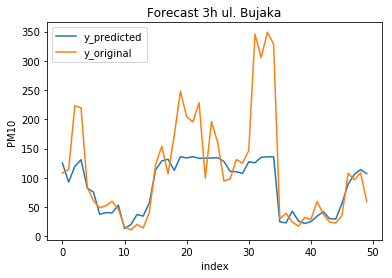

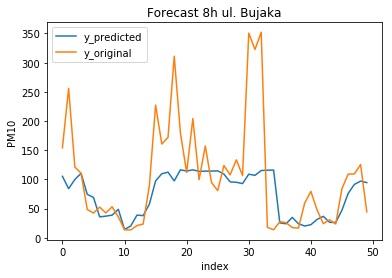

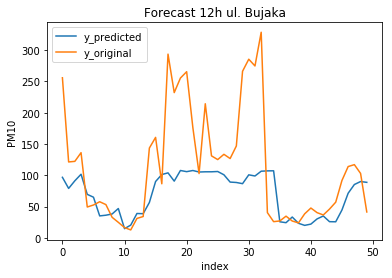

In [27]:
for n in (3, 8, 12):
    show_y_pred_test(y_pred_df, y_test_orig, n=n, size=50, station_name="ul. Bujaka")